# Forecasting Electricity Price in the Spain Using Supervised Learning 

### Team: Minho Kang, Lonny Chen, Johannes Müller, Daniyar Imanaliev


# 1. Background

# 2. Exploratory Data Analysis

In [1]:
import xgboost as xgb
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
from functions import *

In [3]:
df = pd.read_csv('Data/df_clean.csv',index_col="time")

## 2 - 1. Target variable distributions 

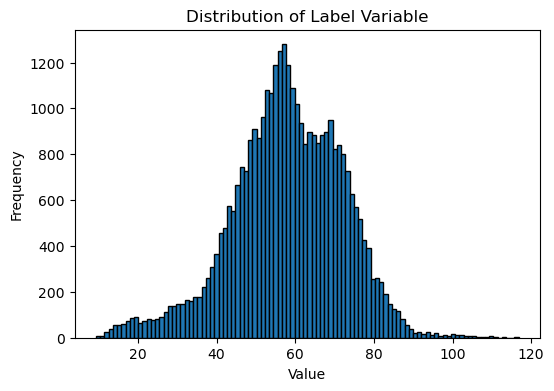

In [4]:
y_col = 'price actual'
y_price = df[y_col]
plt.figure(figsize=(6, 4))
plt.hist(y_price, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Label Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

**Analysis:** 
- `'price actual'` is the "normal looking" distribution which may help performace of linear regression and "some" machine learning algorithms

## 2 - 2. Feature variables (weather) distributions 

Interesting weather features to take a closer look at:
- temperature, pressure, humidity variations across five cities

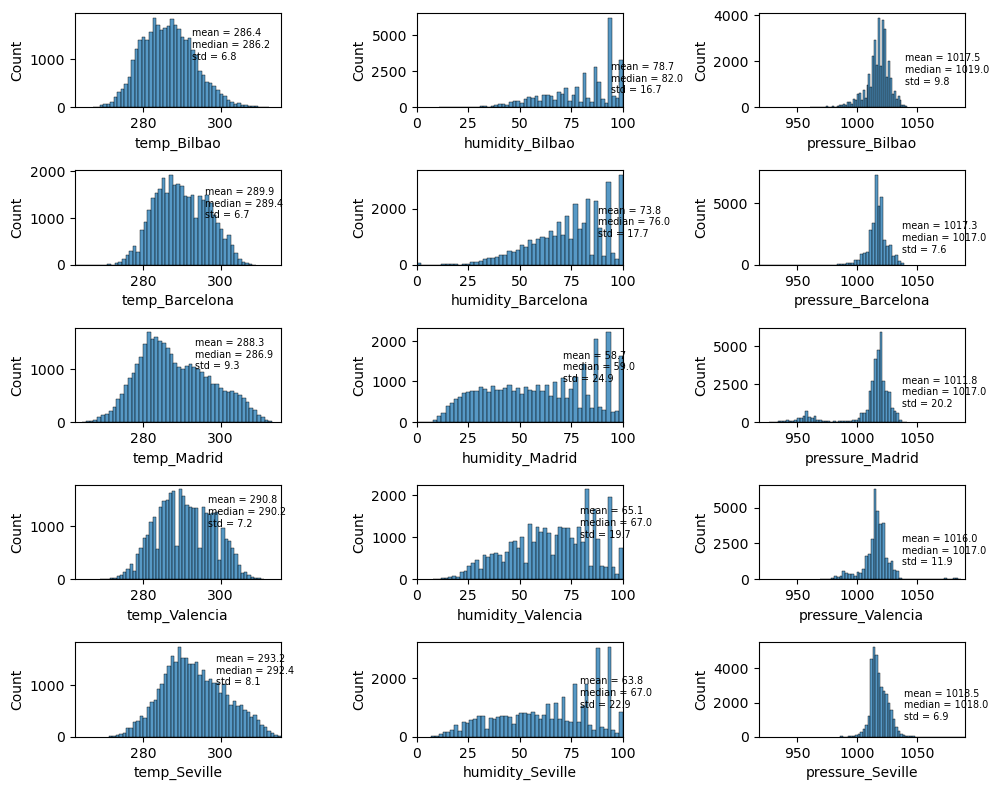

In [5]:
# Setup
weather_cols = [[col for col in df.columns if 'temp' in col],
                [col for col in df.columns if 'humidity' in col],
                [col for col in df.columns if 'pressure' in col]]
# Order by North to South of Spain
for i, _ in enumerate(weather_cols):
    weather_cols[i][0], weather_cols[i][1], weather_cols[i][2], weather_cols[i][3], weather_cols[i][4] = weather_cols[i][1], weather_cols[i][0], weather_cols[i][2], weather_cols[i][4], weather_cols[i][3]

# Get limits for consistent axes
col_mins = [min([min(df[col]) for col in weather_cols[0]]),
            min([min(df[col]) for col in weather_cols[1]]),
            min([min(df[col]) for col in weather_cols[2]])]
col_maxs = [max([max(df[col]) for col in weather_cols[0]]),
            max([max(df[col]) for col in weather_cols[1]]),
            max([max(df[col]) for col in weather_cols[2]])]
fig, axes = plt.subplots(5, 3, figsize=(10, 8))

# Plots and annotate text
for i, x_var in enumerate(weather_cols):
    for j, city in enumerate(x_var):
        sns.histplot(data=df, x=city, bins=50, ax=axes[j][i])
        axes[j][i].set_xlim(left=col_mins[i], right=col_maxs[i])
        hist_text(axes[j][i], np.percentile(df[city], 50), 1000, df[city], 1, 'x-small', False)  
    
plt.tight_layout()
plt.show()

**Observations:** 
- temperature curves do move to the right as we go south, Valencia exhibits some strange dips in the histogram
- humidity curve shapes vary more but it roughly varies inversely to temperature by city (e.g., low temp, high humidity)
- pressure varies little and seems similar in each city

## 2 - 3. Feature variables (generation) correlations

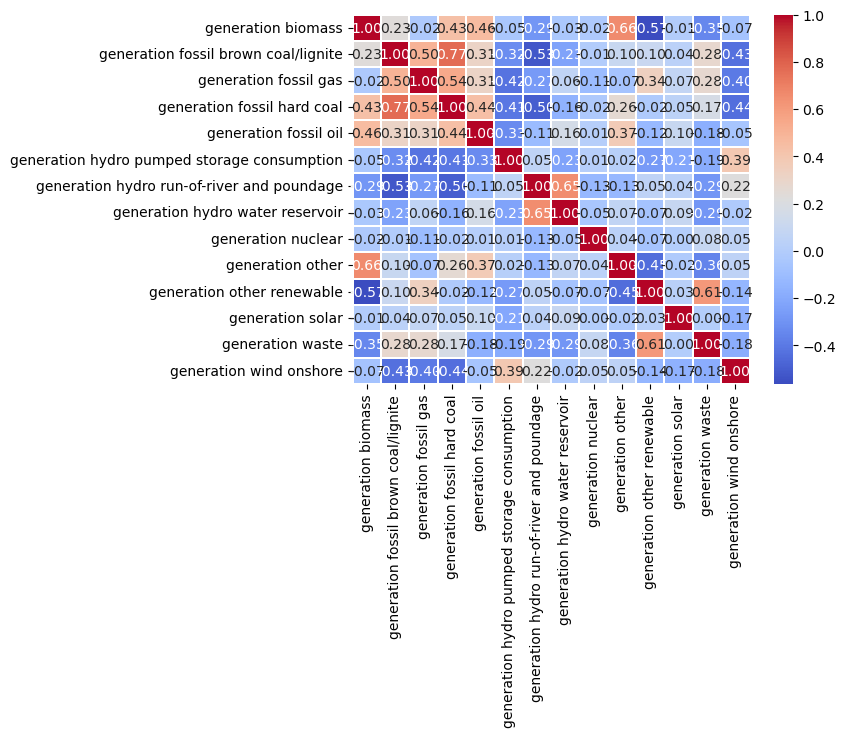

In [6]:
# Calculate correlations
df2 = df.copy()
generation_cols = [col for col in df2.columns if 'generation' in col]
df2_generation_corr = df2[generation_cols].corr(method='pearson')

# Plot heatmap
sns.heatmap(df2_generation_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.rcParams['font.size'] = 6

## 2 - 4. Target variable correlations

Last, we are looking at which features have high pearson correlation with y variable (`price actual`)

In [7]:
s_y_corr = df.corr(method='pearson')[y_col].sort_values(ascending=False)
s_y_corr[abs(s_y_corr) >= 0.3]

price actual                                   1.000000
price_prev_1                                   0.966790
price_prev_2                                   0.900490
price_prev_3                                   0.821566
price day ahead                                0.732167
generation fossil hard coal                    0.465953
generation fossil gas                          0.461567
total load forecast                            0.435918
total load actual                              0.435638
generation fossil brown coal/lignite           0.364006
generation hydro pumped storage consumption   -0.426251
Name: price actual, dtype: float64

**Observations:**
- There are no moderate or strong correlations with any of the weather variables!
- High correlations relate to previous or "day ahead" prices
- Moderate correlations relate to fossil generation (more expensive?) and total loads (market)

**Analysis**
- The metric here is Pearson "linear" correlation which may foreshadow poor predictabiltiy using linear regression models

# 3. Feature Engineering using XGBoost 

Here, as one part of feature engineering, we are going to do dimensional reduction using XGBoost. Specifically, we will use only top 10 important features based on the result of feature importance from XGBoost. 

## 3 - 1. Data Preprocessing 

In [8]:
X = df.drop(columns=['price actual'])
y_price = df['price actual']

In [9]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
# Here, we are using ourselves made function named "split_by_date"
X_train, X_test = split_by_date(X,train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)

In [10]:
# Standardize X variables. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3 - 2. Hyperparameter Tuning

In [11]:
xgb_reg = xgb.XGBRegressor(eval_metric = "rmse")
param_grid = {"max_depth": [4,5,6],
              "n_estimators" : [50, 100, 150],
              "learning_rate": [0.01, 0.015]
    
}
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(X_train_scaled, y_price_train)
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")


## 3 - 3. Find top 10 features

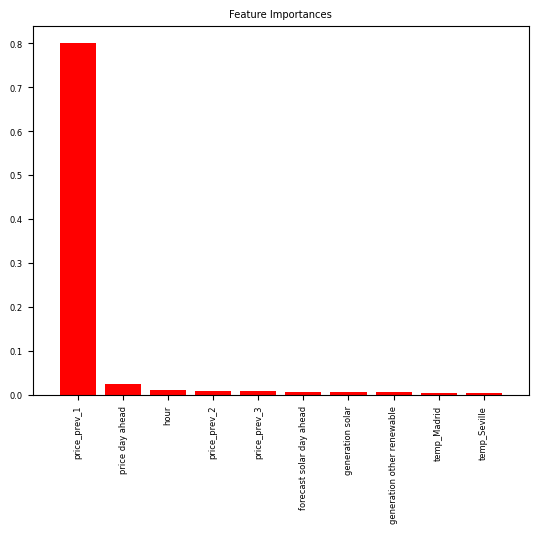

In [12]:
xgb_reg.fit(X_train_scaled, y_price_train)
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]
top_10_indices = indices[:10]
top_10_features = X_train.columns[top_10_indices]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(len(top_10_indices)), importances[top_10_indices], color='r', align='center')
plt.xticks(range(len(top_10_indices)), top_10_features, rotation=90)
plt.xlim([-1,len(top_10_indices)])
plt.show()

X_10 = df[top_10_features]

# 4. Model Evaluation

In [13]:
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X_10,train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)
# Standardize X variable 
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
# Stadardize Y variable (This is depending on what model you use)
scaler_y = StandardScaler()
y_price_train_scaled = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
y_price_test_scaled = scaler_y.fit_transform(y_price_test.values.reshape(-1, 1))

## 4 - 1. Linear Regression

## 4 - 2. Ridge and Lasso

## 4 - 3. Kernel

## 4 - 4. KNN

### 4 - 4 - 1. Grid Search 

In [15]:
knn = KNeighborsRegressor()
# Set the candidates with 9,11,13,15,17
param_grid = {
    'n_neighbors': [9,11,13,15,17],
    'metric': ['euclidean', 'manhattan']
}
cv_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

### 4 - 4 - 2. Prediction and Evaluation

In [16]:
cv_knn.fit(X_train_scaled, y_price_train_scaled)
# Prediction 
y_price_pred_scaled_knn = cv_knn.predict(X_test_scaled)
y_price_pred_knn = scaler_y.inverse_transform(y_price_pred_scaled_knn)

# MSE
rmse_price = root_mean_squared_error(y_price_test, y_price_pred_knn)
print("RMSE for predicting price:", rmse_price)

RMSE for predicting price: 3.9559091088602476


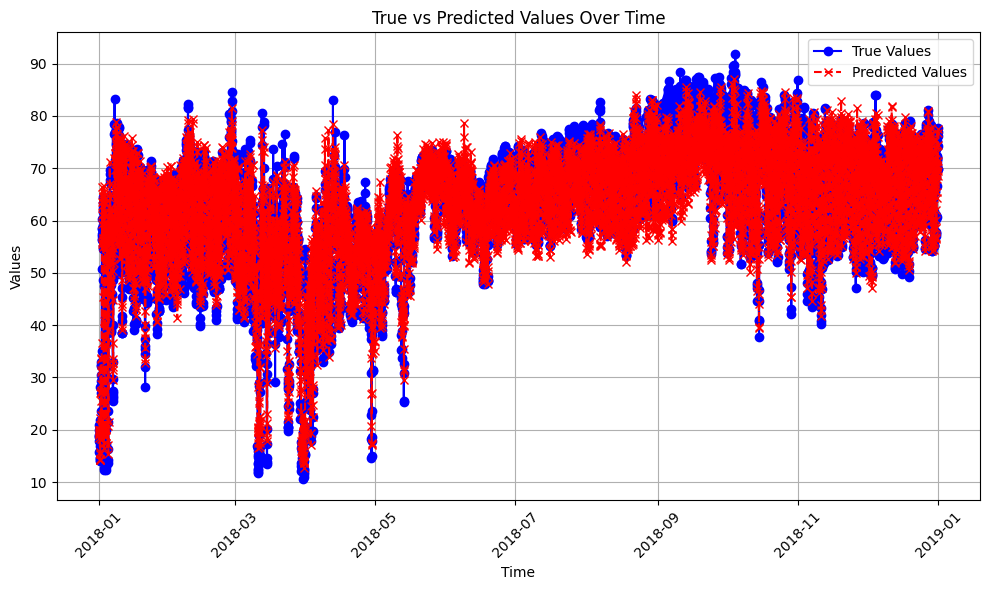

In [19]:
plot_true_pred(X_test, y_price_pred, y_price_test)

## 4 - 5. Tree models (Random Forest and XGboost)

## 4 - 6. RNN

### 4 - 6 - 1. Grid Search

In [37]:
X_train_scaled_rnn = scaler_x.fit_transform(X_train).reshape(-1,1,10)
X_test_scaled_rnn = scaler_x.transform(X_test).reshape(-1,1,10)

y_price_train_scaled_rnn = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
y_price_test_scaled_rnn = scaler_y.transform(y_price_test.values.reshape(-1, 1))

def create_rnn_model(n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, input_shape=(1, n_features)))
    model.add(Dense(1))  # No activation function for regression
    model.compile(optimizer='adam', loss='mse')  # Using mean squared error for regression
    return model


n_features = X_train.shape[1]
n_neurons = [10, 20, 30]
param_grid = dict(model__n_neurons=n_neurons)

model_candi = KerasRegressor(model=create_rnn_model)
grid_rnn = GridSearchCV(model_candi, param_grid, cv=5, n_jobs=-1).fit(X_train_scaled_rnn,y_price_train_scaled_rnn)


822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1969


### 4 - 6 - 2. Prediction and Evaluation

In [43]:
# Prediction
best_rnn = grid_rnn.best_estimator_
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
best_rnn.fit(X_train_scaled_rnn, y_price_train_scaled_rnn, epochs=50, batch_size=20, validation_split=0.2,
                            verbose=0)
y_price_pred_scaled_rnn = best_rnn.predict(X_test_scaled_rnn).reshape(-1,1)
y_price_pred_rnn = scaler_y.inverse_transform(y_price_pred_scaled_rnn)
rmse_price = root_mean_squared_error(y_price_test, y_price_pred_rnn)
print("RMSE for predicting price:", rmse_price)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE for predicting price: 2.64133319322307


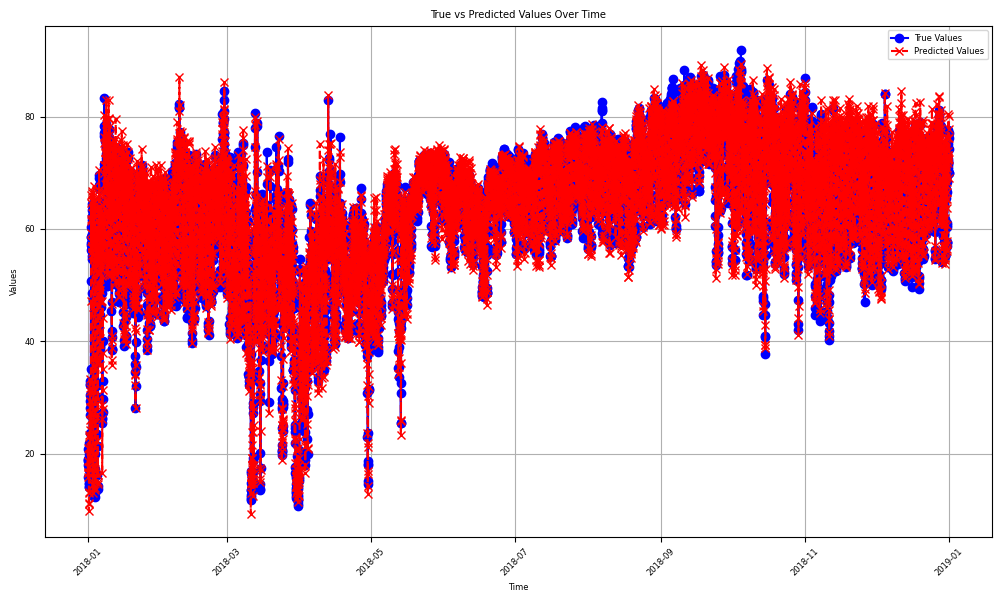

In [52]:
# Evaluaton 
plot_true_pred(X_test, y_price_pred_rnn, y_price_test)

### 

## 4 - 7. Time Series Model

From various time-series models, we utilyzed SARIMAX model (The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors). SARIMAX is a time series forecasting technique that extends the traditional ARIMA model to account for seasonality and external factors. SARIMAX model is extension of ARIMA model and part of auto regressive time series models

SARIMAX model is suitable for energy price prediction since during exploratory data analysis we identified that price data has a strong seasonal effect, as well as our dataset has other variables which can serve as Exogenous Regressors for SARIMAX model

### 4 - 7 - 1 Building function for SARIMAX

In [14]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    - results: Fitted SARIMAX model object containing detailed diagnostic information about the model.
    - forecast: Forecast object containing information like predicted values, confidence intervals, etc.,
    for the test set.
    - mean_forecast: Array of predicted mean values from the forecast, which can be directly 
    compared to y_test for evaluation.

    """
    model = SARIMAX(y_train,
                    exog=X_train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

### Tuning the SARIMAX model for the best parameters

Let's start from parameters p=1, d=0, q=1, P=1, D=0, Q=1, based on ASF and PASF plots (please refer to ARIMA folder in Github)\
Unfortunately, due to limitation of computational power, grid search or cross validation is not possible, however, we can identify parameters by hand

In [16]:
rmse_2, results_2, forecast_2, mean_forecast_2 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled,                                                                         
                                                                         1, 0, 2, 1, 0, 2, 12)

In [17]:
rmse_2

2.8471669708664127

In [20]:
#p=1, d=0, q=1, P=1, D=0, Q=1
rmse_1, results_1, forecast_1, mean_forecast_1 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled, 1, 0, 1, 1, 0, 1, 12)
print(rmse_1)

2.817080678920126


In [21]:
#p=1, d=0, q=2, P=1, D=1, Q=2
rmse_3, results_3, forecast_3, mean_forecast_3 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled, 1, 0, 2, 1, 1, 2, 12)
print(rmse_3)

6.108357846549517


In [22]:
#p=1, d=0, q=0, P=1, D=0, Q=0
rmse_4, results_4, forecast_4, mean_forecast_4 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled, 1, 0, 0, 1, 0, 0, 12)
print(rmse_4)

23.449259171110874


**Accordingly, a model with parameters p=1, d=0, q=1, P=1, D=0, Q=1 gives us the best results** 

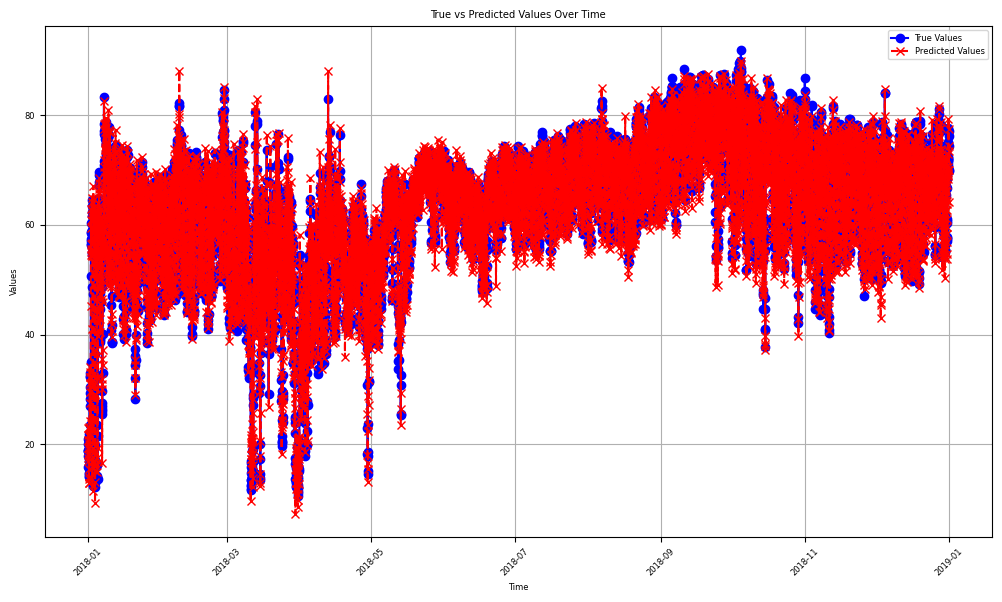

In [23]:
plot_true_pred(X_test, mean_forecast_1, y_price_test)

In [24]:
print(results_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       price actual   No. Observations:                26302
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -62545.942
Date:                            Tue, 21 May 2024   AIC                         125121.883
Time:                                    18:49:55   BIC                         125244.536
Sample:                                01-01-2015   HQIC                        125161.487
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            20.0579      0.070    284.897      0.000      19.920      20.196
x2             1.0138      0.030   

# 5. The final model

# 6. Discussion and Conclusion